In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# User controls
# -----------------------------
seed = 42

t0 = 2000.0
duration_years = 10.0
t1 = t0 + duration_years

events_per_year = 2
n_events = int(events_per_year * duration_years)   # 20 events for 10 years

# event timing: inter-event intervals (years)
mean_interval = 0.5
sd_interval   = 0.25

# event magnitude distribution (meters): mean 1 mm, sd 0.25 mm
mean_event_m = 1e-3
sd_event_m   = 0.25e-3

# rescaling target: SLR rate * duration
slr_rate_mm_per_yr = 2.0
target_total_m = (slr_rate_mm_per_yr * duration_years) * 1e-3  # mm -> m

# negative "shock" in year 5 relative to t0
neg_event_target_year = t0 + 5.0
neg_multiplier = 4.0

out_csv = f"barrier_island_overwash_events_{int(t0)}_{int(t1)}.csv"

# -----------------------------
# Helpers
# -----------------------------
def make_event_times(t0, t1, n, mean_dt, sd_dt, rng):
    """
    Draw n intervals from N(mean_dt, sd_dt) (truncated to >0), cumulate,
    then linearly rescale so final time hits t1 exactly.
    """
    dt = rng.normal(mean_dt, sd_dt, size=n)
    while np.any(dt <= 0):
        bad = dt <= 0
        dt[bad] = rng.normal(mean_dt, sd_dt, size=bad.sum())

    t = t0 + np.cumsum(dt)

    # rescale to end exactly at t1 (preserve ordering/relative spacing)
    scale = (t1 - t0) / (t[-1] - t0)
    t = t0 + (t - t0) * scale
    return t

# -----------------------------
# Main simulation
# -----------------------------
rng = np.random.default_rng(seed)

# 1) event times (decimal years)
t = make_event_times(t0, t1, n_events, mean_interval, sd_interval, rng)

# 2) raw magnitudes (meters)
raw = rng.normal(mean_event_m, sd_event_m, size=n_events)

# (Optional) enforce positive-only accretion in the baseline series
# raw = np.abs(raw)

# 3) Version 1: scale all events to hit target_total_m
scale_v1 = target_total_m / raw.sum()
v1 = raw * scale_v1

# 4) Version 2: inject a negative event near year 5; keep others as v1
idx_neg = int(np.argmin(np.abs(t - neg_event_target_year)))

v2 = v1.copy()
mean_pos = np.mean(v1[v1 > 0]) if np.any(v1 > 0) else np.mean(v1)
v2[idx_neg] = -neg_multiplier * mean_pos  # negative shock

# 5) Version 3: same as v2, but rescale subsequent positive events to restore total to target_total_m
v3 = v2.copy()

post = np.arange(n_events) > idx_neg
post_pos = post & (v3 > 0)

sum_pre = v3[~post].sum()                 # includes the negative event
sum_post_other = v3[post & ~post_pos].sum()
sum_post_pos = v3[post_pos].sum()

needed_for_post_pos = target_total_m - (sum_pre + sum_post_other)

if sum_post_pos != 0:
    scale_post = needed_for_post_pos / sum_post_pos
    v3[post_pos] *= scale_post
# else: no positive events after shock; v3 remains v2

# -----------------------------
# Output table (decimal years + three event columns)
# -----------------------------
df = pd.DataFrame({
    "decimal_year": t,
    "event_v1_m": v1,
    "event_v2_m": v2,
    "event_v3_m": v3,
})

# Also add mm columns for readability (optional)
df["event_v1_mm"] = df["event_v1_m"] * 1e3
df["event_v2_mm"] = df["event_v2_m"] * 1e3
df["event_v3_mm"] = df["event_v3_m"] * 1e3

# have written this out...uncomment to write a new version
# df.to_csv(out_csv, index=False)

In [38]:
# read in the data from the last saved run
df = pd.read_csv( out_csv )
t = df("decimal_year").values
v1 = df("event_v1_m").values
v2 = df("event_v2_m").values
v3 = df("event_v3_m").values

,decimal_year,event_v1_m,event_v2_m,event_v3_m,event_v1_mm,event_v2_mm,event_v3_mm
0,2000.585825,0.000928,0.000928,0.000928,0.928379,0.928379,0.928379
1,2000.829848,0.000808,0.000808,0.000808,0.807665,0.807665,0.807665
2,2001.528972,0.001271,0.001271,0.001271,1.270858,1.270858,1.270858
3,2002.276421,0.000936,0.000936,0.000936,0.935760,0.935760,0.935760
4,2002.288867,0.000869,0.000869,0.000869,0.869134,0.869134,0.869134
5,2002.466243,0.000888,0.000888,0.000888,0.887675,0.887675,0.887675
6,2003.007109,0.001103,0.001103,0.001103,1.102896,1.102896,1.102896
7,2003.435095,0.001062,0.001062,0.001062,1.062291,1.062291,1.062291
8,2003.939196,0.001074,0.001074,0.001074,1.073798,1.073798,1.073798
9,2004.230735,0.001078,0.001078,0.001078,1.078200,1.078200,1.078200


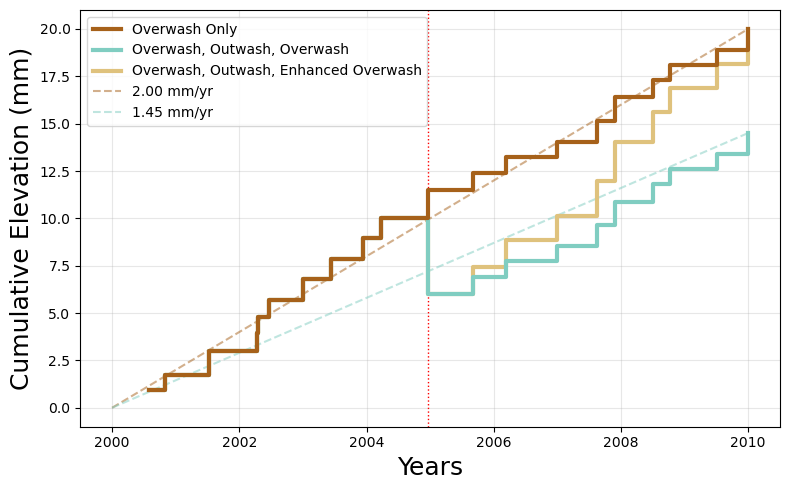

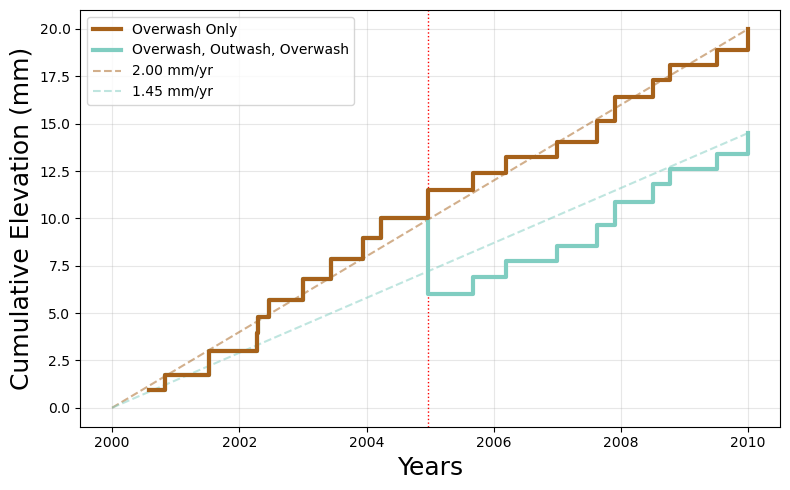

Saved: barrier_island_overwash_events_2000_2010.csv
Target total (mm): 20.000
Totals (mm):
  v1: 19.999999999999996
  v2: 14.505486251640868
  v3: 20.0
Negative event at time: 2004.9626362159736 year; magnitude (mm): -3.999999999999999


In [35]:
colors = ['#a6611a','#dfc27d','#80cdc1','#018571']



# -----------------------------
# Plot: stair-step cumulative elevation + reference SLR line
# -----------------------------
cum1 = np.cumsum(v1) * 1e3  # mm
cum2 = np.cumsum(v2) * 1e3
cum3 = np.cumsum(v3) * 1e3

plt.figure(figsize=(8, 5))

# Reference SLR line (2 mm/yr starting at t0)
t_line = np.array([t0, t1])
slr_mm = (t_line - t0) * slr_rate_mm_per_yr
h4=plt.plot(t_line, slr_mm, linestyle="--", c=colors[0], label=f"{slr_rate_mm_per_yr:.2f} mm/yr", alpha=.5)

slr_rate_mm_slow = cum2[-1]/(t_line[-1] - t0)
cum2[-1]
h5=plt.plot(t_line, slr_mm_slow, linestyle="--", c=colors[2], label=f"{slr_rate_mm_slow:.2f} mm/yr", alpha=.5)

# Mark outwash time
plt.axvline(t[idx_neg], linestyle=":", c='red', linewidth=1)

h3=plt.step(t, cum3, where="post", linewidth = 3, c = colors[1], label="Overwash, Outwash, Enhanced Overwash")
h2=plt.step(t, cum2, where="post", linewidth = 3, c = colors[2], label="Overwash, Outwash, Overwash")
h1=plt.step(t, cum1, where="post", linewidth = 3, c = colors[0], label="Overwash Only")

plt.xlabel("Years", fontsize=18)
plt.ylabel("Cumulative Elevation (mm)", fontsize=18)
# plt.title(f"Barrier elevation change as step-like overwash events ({int(t0)}–{int(t1)})")
plt.grid(True, alpha=0.3)

handles = [h1[0], h2[0], h3[0], h4[0], h5[0]]
labels = [h.get_label() for h in handles]
plt.legend(handles, labels)

plt.tight_layout()
plt.savefig('cum_with_enhanced_ow.png')
plt.show()

# Second figure without catch-up
plt.figure(figsize=(8, 5))

# Reference SLR line (2 mm/yr starting at t0)
t_line = np.array([t0, t1])
slr_mm = (t_line - t0) * slr_rate_mm_per_yr
h4=plt.plot(t_line, slr_mm, linestyle="--", c=colors[0], label=f"{slr_rate_mm_per_yr:.2f} mm/yr", alpha=.5)
h5=plt.plot(t_line, slr_mm_slow, linestyle="--", c=colors[2], label=f"{slr_rate_mm_slow:.2f} mm/yr", alpha=.5)

# Mark outwash time
plt.axvline(t[idx_neg], linestyle=":", c='red', linewidth=1)

#plt.step(t, cum3, where="post", linewidth = 3, c = colors[1], label="Overwash, Outwash, Enhanced Overwash")
plt.step(t, cum2, where="post", linewidth = 3, c = colors[2], label="Overwash, Outwash, Overwash")
plt.step(t, cum1, where="post", linewidth = 3, c = colors[0], label="Overwash Only")

plt.xlabel("Years", fontsize=18)
plt.ylabel("Cumulative Elevation (mm)", fontsize=18)
# plt.title(f"Barrier elevation change as step-like overwash events ({int(t0)}–{int(t1)})")
plt.grid(True, alpha=0.3)
handles = [h1[0], h2[0], h4[0], h5[0]]
labels = [h.get_label() for h in handles]
plt.legend(handles, labels)
plt.tight_layout()
plt.savefig('cum_wo_enhanced_ow.png')
plt.show()

# -----------------------------
# Quick checks
# -----------------------------
print("Saved:", out_csv)
print(f"Target total (mm): {target_total_m*1e3:.3f}")
print("Totals (mm):")
print("  v1:", v1.sum() * 1e3)
print("  v2:", v2.sum() * 1e3)
print("  v3:", v3.sum() * 1e3)
print("Negative event at time:", t[idx_neg], "year; magnitude (mm):", v2[idx_neg] * 1e3)